In [53]:
import analysis_utils as au
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import quick_metadata_plots as mplts
import analysis_utils as au
import padeopsIO as pio
import pandas as pd
import seaborn as sns

In [54]:
from UnifiedMomentumModel.Momentum import UnifiedMomentum

In [55]:
data_path = Path(au.DATA_PATH)
sim_folder = os.path.join(au.DATA_PATH, "B_0001_Files")
rows, fields = mplts.get_sim_varied_params(sim_folder)
ids, cT, yaw, tilt, filterWidth = zip(*rows)

In [56]:
nruns = 32
runs = range(0, nruns)
avg_power_runs = [0] * nruns
cT_vals = [0] * nruns
yaw_vals = [0] * nruns
tilt_vals = [0] * nruns
effective_angle = [0] * nruns
for i in runs:
    try:
        run_folder = au.get_run_folder(sim_folder, i)
        sim = pio.BudgetIO(run_folder, padeops = True, runid = 0)
        mean_dt = sim.get_dt()
        power = sim.read_turb_power("all", turb=1)[round(100 / mean_dt):]
        avg_power = np.mean(power)
        avg_power_runs[i] = avg_power
        cT_vals[i] = float(cT[i])
        yaw_vals[i] = float(yaw[i])
        tilt_vals[i] = float(tilt[i])
        effective_angle[i] = np.rad2deg(np.arccos(np.cos(np.deg2rad(yaw_vals[i])) * np.cos(np.deg2rad(tilt_vals[i]))))
    except:
        continue

avg_cp = [au.power_to_Cp(p) for p in avg_power_runs]

/work2/10264/sgering/stampede3/src/padeopsIO/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0000 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")
/work2/10264/sgering/stampede3/src/padeopsIO/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0001 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")
/work2/10264/sgering/stampede3/src/padeopsIO/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0002 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")
/work2/10264/sgering/stampede3/src/padeopsIO/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0003 no budget files found.
  warnings.warn(f"_init_padeops(): {self.filename} no budget files found.")
/work2/10264/sgering/stampede3/src/padeopsIO/padeopsIO/budgetIO.py:254: UserWarning: _init_padeops(): Sim_0004 no budget files found.
  warnings.warn(f"_init_pa

In [57]:
data = {"cT": cT_vals,
        "yaw": yaw_vals,
        "tilt": tilt_vals,
        "angle": effective_angle,
        "cP": avg_cp,
        }
df = pd.DataFrame(data)
df

,cT,yaw,tilt,angle,cP
0,1.0,0.0,0.0,0.000000,0.518540
1,1.0,0.0,10.0,10.000000,0.501013
2,1.0,0.0,20.0,20.000000,0.449799
3,1.0,0.0,30.0,30.000000,0.370121
4,1.0,10.0,0.0,10.000000,0.500954
5,1.0,10.0,10.0,14.106044,0.483823
6,1.0,10.0,20.0,22.268744,0.433862
7,1.0,10.0,30.0,31.474949,0.356466
8,1.0,20.0,0.0,20.000000,0.449591
9,1.0,20.0,10.0,22.268744,0.433721


In [98]:
yaws = df.yaw.unique()
yaws.sort()
yaws_rad = np.deg2rad(yaws)
model = UnifiedMomentum()
umm_cp_ct1 = [model(Ctprime = 1, yaw = y).Cp[0] for y in yaws_rad]
umm_cp_ct4 = [model(Ctprime = 4, yaw = y).Cp[0] for y in yaws_rad]

In [99]:
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

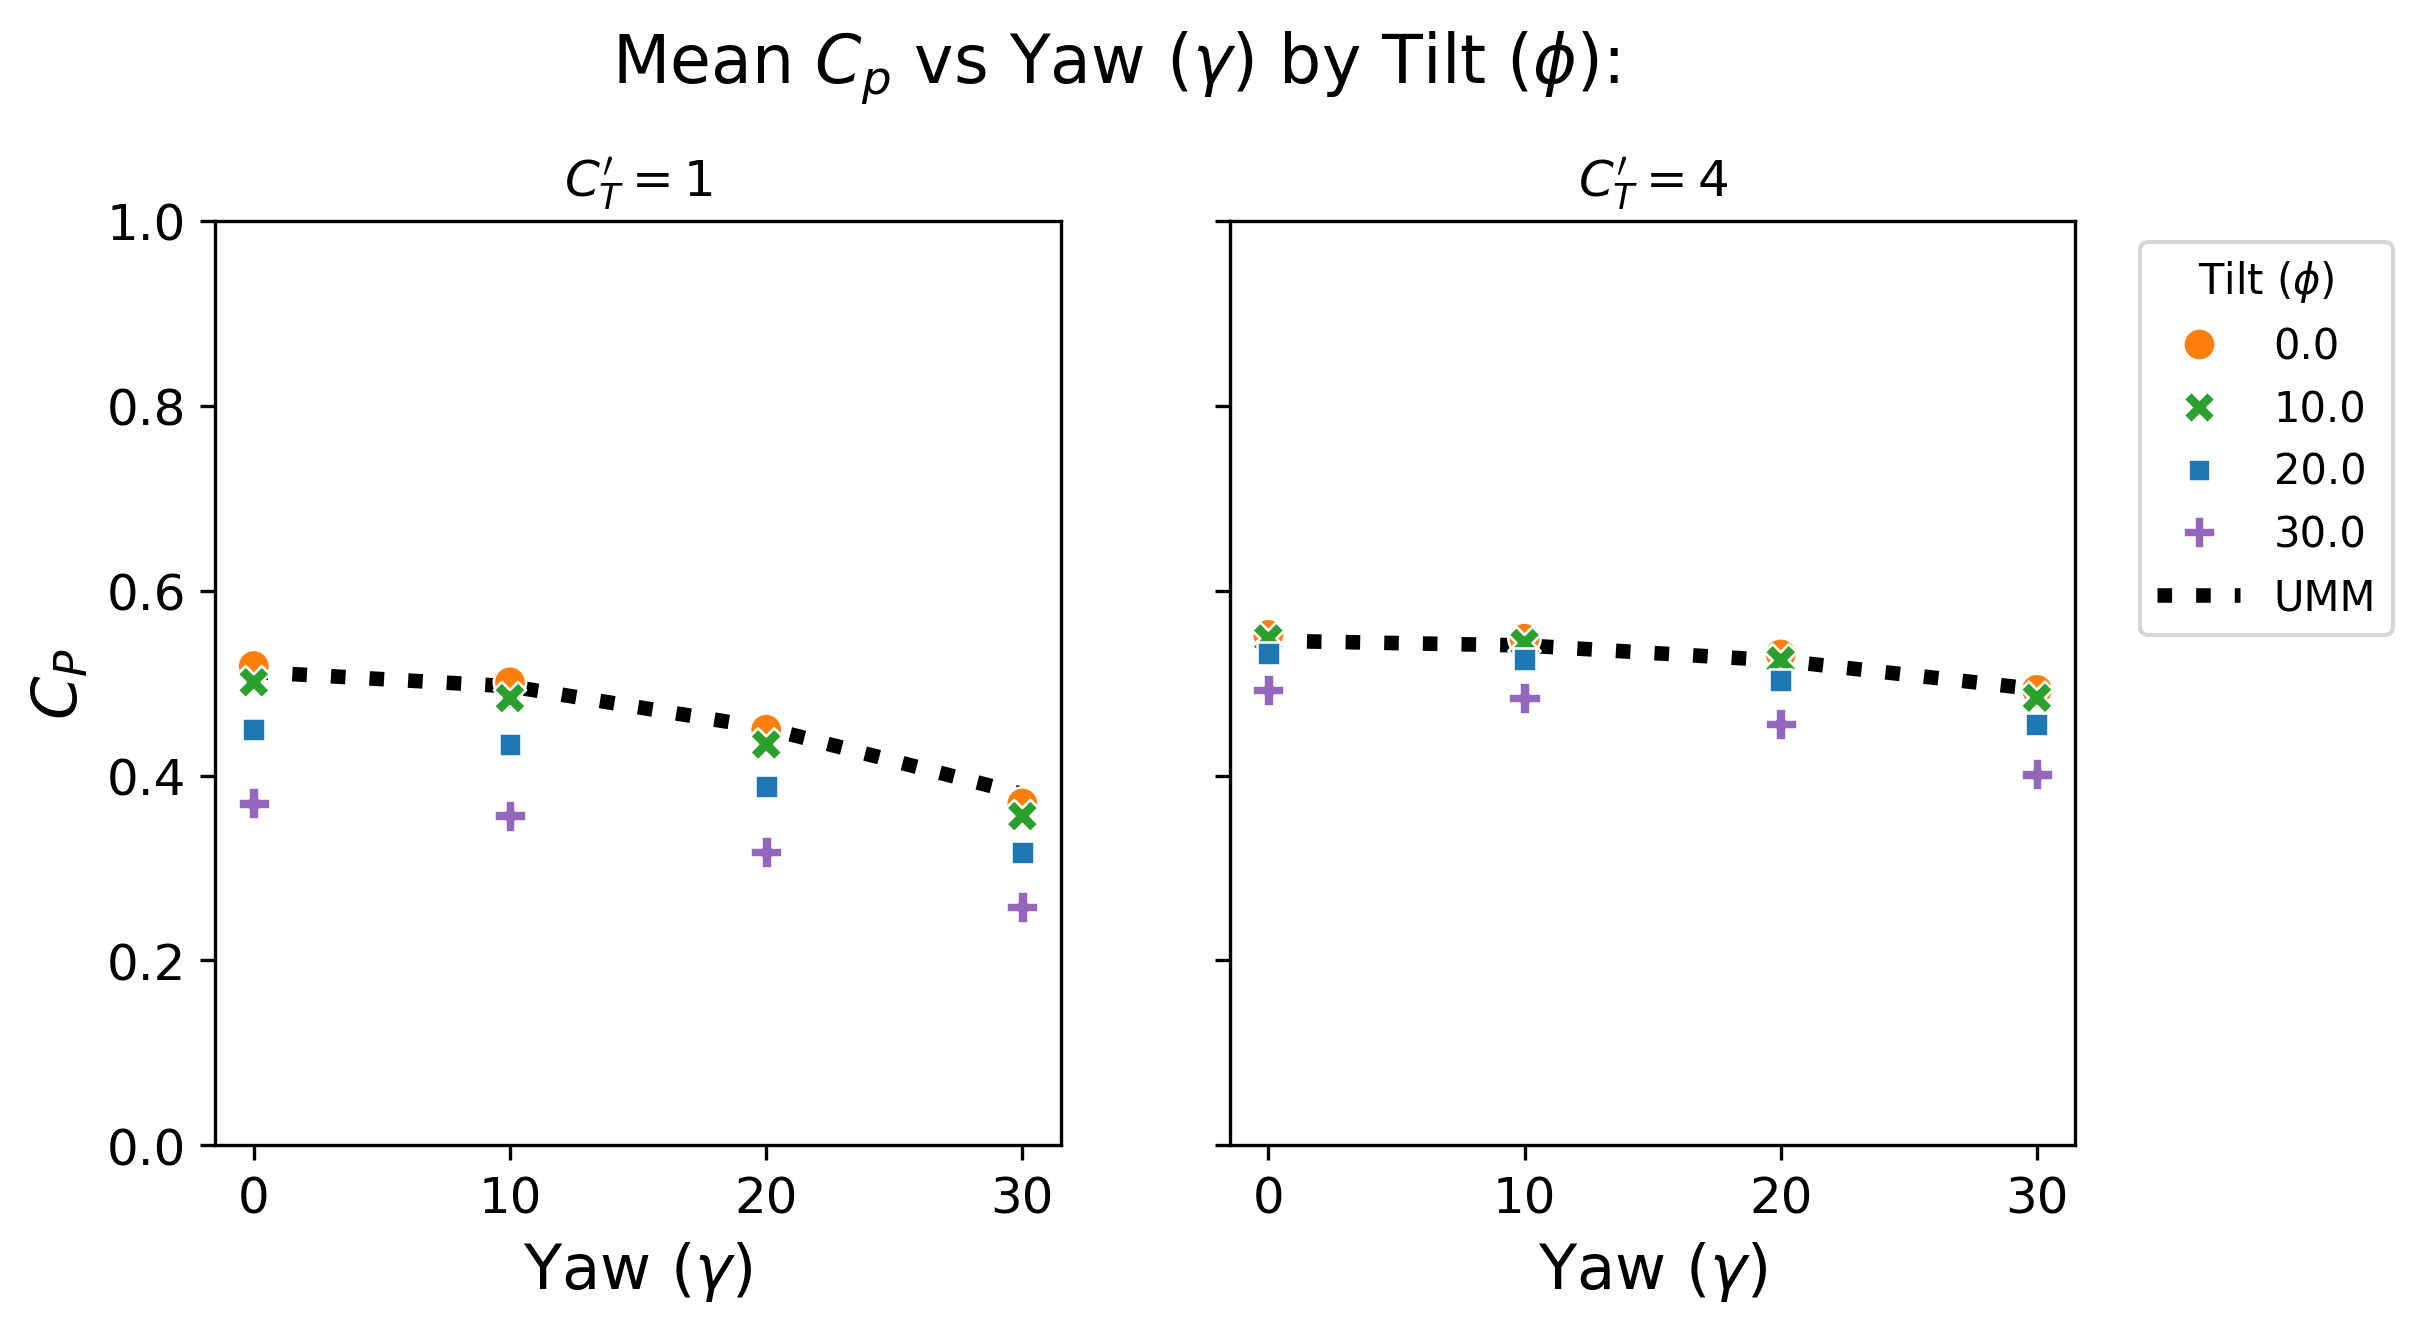

In [107]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, dpi = 300, figsize = (8, 4))
fig.suptitle("Mean $C_p$ vs Yaw ($\gamma$) by Tilt ($\phi$):", size = 16, y = 1.04)

ax0.set_title("$C_T' = 1$")
ax0.set_xlabel('Yaw ($\gamma$)', size = 15)
ax0.set_ylabel('$C_P$', size = 15)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(0, 1)

ax1.set_title("$C_T' = 4$")
ax1.set_xlabel('Yaw ($\gamma$)', size = 15)
ax1.tick_params(axis='both', which='major', labelsize=12)

linewidth = 3.5

sns.scatterplot(ax = ax0, data = df[df["cT"] == 1], x = "yaw", y = "cP", hue = "tilt", style = "tilt", palette = palette, zorder = 5,  s=60)
sns.scatterplot(ax = ax1, data = df[df["cT"] == 4], x = "yaw", y = "cP", hue = "tilt", style = "tilt", palette = palette, zorder = 5,  s=60, legend = False)

sns.lineplot(ax = ax0, x = yaws, y = umm_cp_ct1, color = 'k', linestyle = "dotted", linewidth = linewidth, label = "UMM")
sns.lineplot(ax = ax1, x = yaws, y = umm_cp_ct4, color = 'k', linestyle = "dotted", linewidth = linewidth)

leg = ax0.legend(title='Tilt ($\phi$)')
bb = leg.get_bbox_to_anchor().transformed(ax0.transAxes.inverted())
xOffset = 1.6
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax0.transAxes)

In [62]:
angles = df.angle.unique()
angles.sort()
angles_rad = np.deg2rad(angles)
model = UnifiedMomentum()
umm_cp_ct1 = [model(Ctprime = 1, yaw = y).Cp[0] for y in angles_rad]
umm_cp_ct4 = [model(Ctprime = 4, yaw = y).Cp[0] for y in angles_rad]

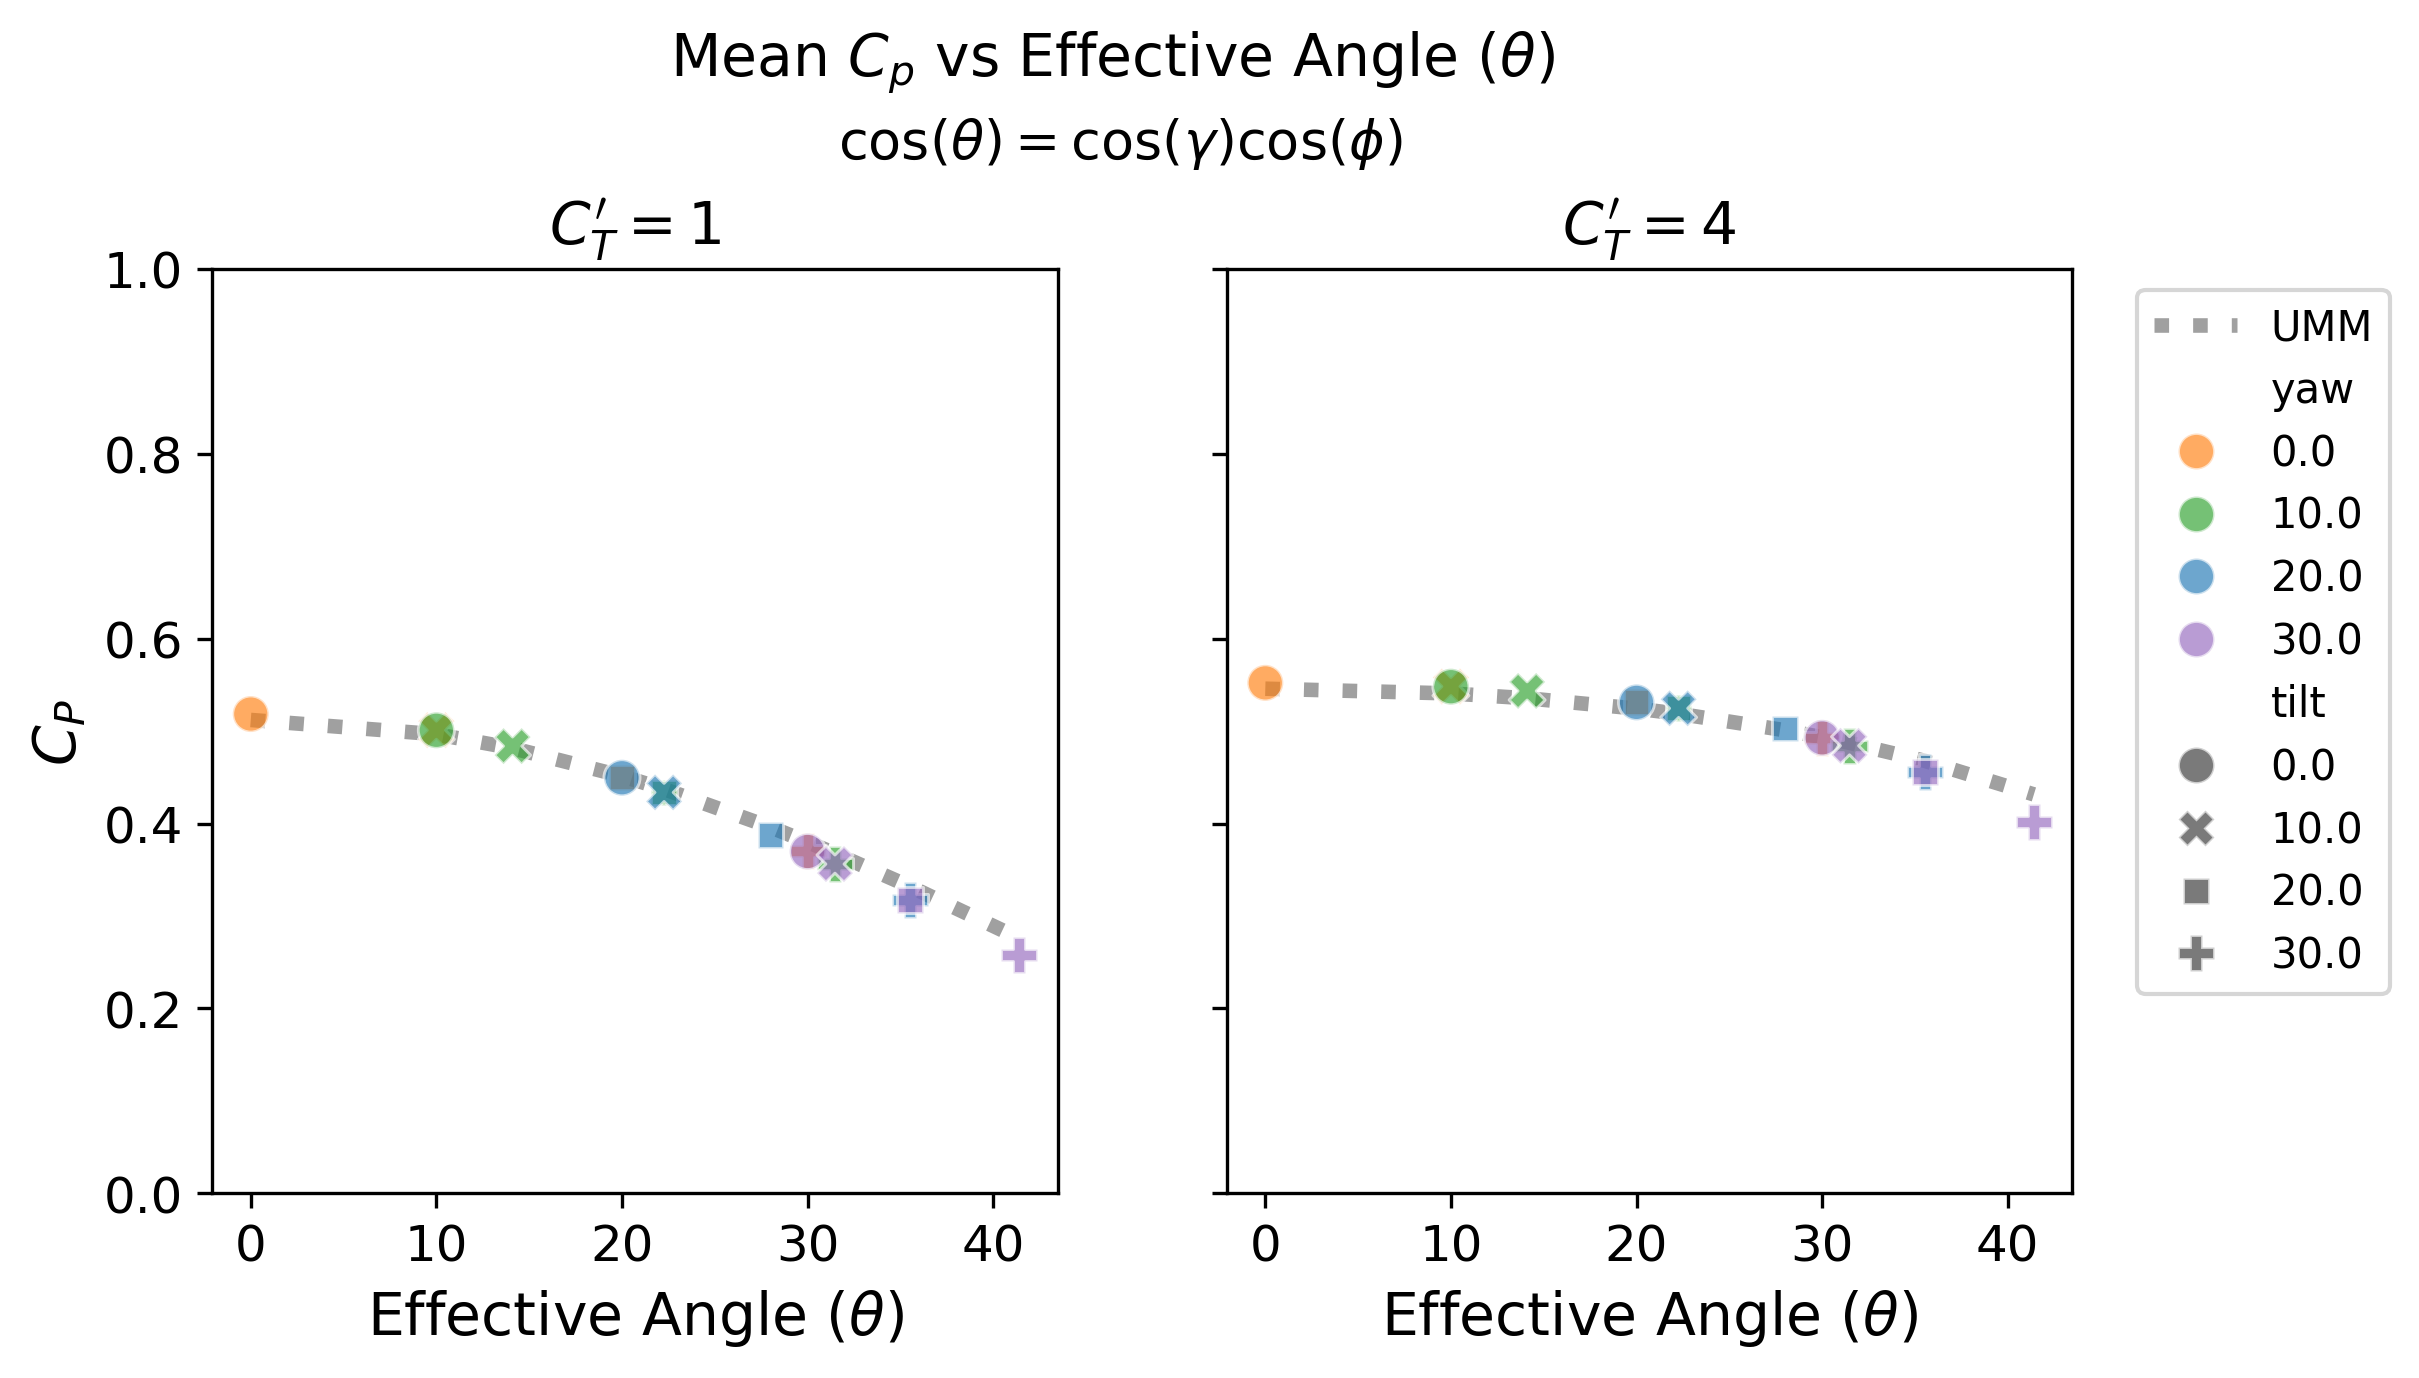

In [96]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, dpi = 300, figsize = (8, 4))
fig.suptitle("Mean $C_p$ vs Effective Angle ($\\theta$)", size = 14, y = 1.08)
plt.text(x=-23, y=1.12, s='$\cos(\\theta) = \cos(\gamma)\cos(\phi)$', fontsize=13)
# fig.suptitle("Mean $C_p$ vs Effective Angle $/theta$ ($cos(\theta) = \cos(\gamma) \cos(\phi)$):", size = 16, y = 1.04)
ax0.set_title("$C_T' = 1$", size = 14)
ax0.set_xlabel('Effective Angle ($\\theta$)', size = 14)
ax0.set_ylabel('$C_P$', size = 14)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(0, 1)

ax1.set_title("$C_T' = 4$", size = 14)
ax1.set_xlabel('Effective Angle ($\\theta$)', size = 14)
ax1.tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(ax = ax0, x = angles, y = umm_cp_ct1, color = 'grey', linestyle = "dotted", linewidth = linewidth, label = "UMM", alpha = 0.75)
sns.lineplot(ax = ax1, x = angles, y = umm_cp_ct4, color = 'grey', linestyle = "dotted", linewidth = linewidth, alpha = 0.75)

sns.scatterplot(ax = ax0, data = df[df["cT"] == 1], x = "angle", y = "cP", hue = "yaw", style = "tilt", palette = palette, zorder = 5, s=75, alpha = 0.65)
sns.scatterplot(ax = ax1, data = df[df["cT"] == 4], x = "angle", y = "cP", hue = "yaw", style = "tilt", palette = palette, zorder = 5, s=75, alpha = 0.65, legend = False)

leg = ax0.legend()
bb = leg.get_bbox_to_anchor().transformed(ax0.transAxes.inverted())
xOffset = 1.6
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax0.transAxes)
